500 500


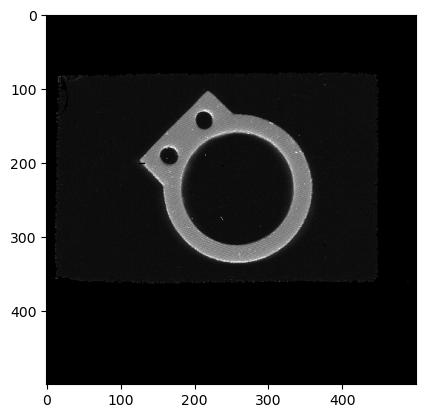

In [30]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
image_path = r"C:\Part_dimensions_project\Semantic_segmentation_2\images\train\Big_circle_1.tif"
image = cv2.imread(image_path)
# image = image[500:3000, 1000:4000]
# cv2.imwrite(r"C:\Part_dimensions_project\Big_circle_cropped.jpg" , image)


gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
(H, W) = gray_image.shape[:2]

if gray_image is None:
    print(f"Error: Unable to load image at {image_path}")

else :
    plt.imshow(gray_image , cmap = 'gray')


_, binary_img = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

cv2.imwrite(r"C:\Part_dimensions_project\Semantic_segmentation_2\images\train\Big_circle_1.tif", binary_img)


print(H , W)

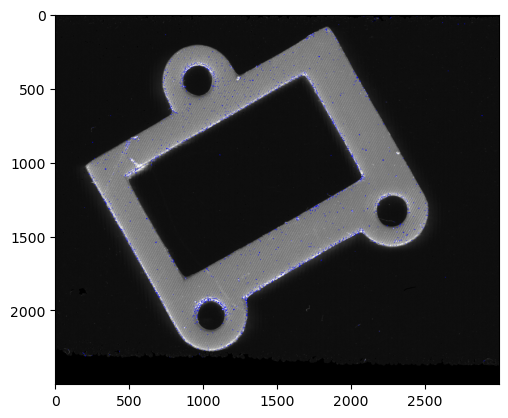

In [38]:
#CORNER DETECTION

gray_float = np.float32(gray_image)

# Apply Harris Corner Detection
block_size = 2
aperture_size = 3
k = 0.04
dst = cv2.cornerHarris(gray_float, block_size, aperture_size, k)

# Result is dilated for marking the corners, not important
dst = cv2.dilate(dst, None)

# Threshold for an optimal value, it may vary depending on the image
image[dst > 0.01 * dst.max()] = [0, 0, 255]


plt.imshow(image)

(2500, 3000)


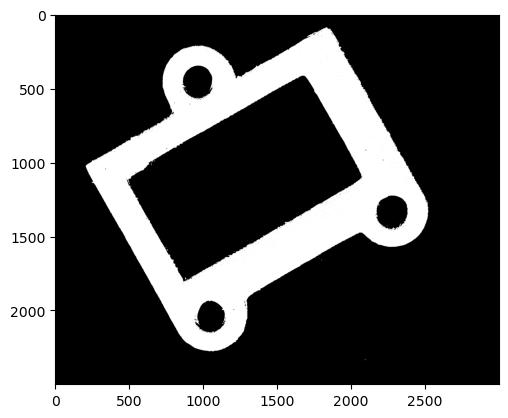

In [2]:
import numpy as np
_, binary_img = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)
# edges = cv2.Canny(binary_img, 50, 200)
#plt.imshow(binary_img , cmap = 'gray')
kernel = np.ones((3, 3), np.uint8)
filtered_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)
print(filtered_img.shape)
plt.imshow(filtered_img , cmap = 'gray')
# cv2.imwrite(r'C:\Part_dimensions\filtered_image2.jpg' , filtered_img)

In [3]:
filtered_rgb = np.stack((filtered_img,) * 3, axis=-1)
print(filtered_rgb.shape)
# plt.imshow(filtered_rgb)

image_batch = np.expand_dims(image, axis=0)


filtered_transposed = np.transpose(image_batch, (0, 3, 1, 2))

(2500, 3000, 3)


In [4]:

mean_pixel_values= np.average(image, axis = (0,1))
#print(mean_pixel_values)
blob = cv2.dnn.blobFromImage(image, scalefactor=0.8, size=(W, H),
                             mean=(mean_pixel_values[0], mean_pixel_values[1] , mean_pixel_values[2]),
                             swapRB= False, crop=False)

(1, 3, 2500, 3000)
(2500, 3000, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


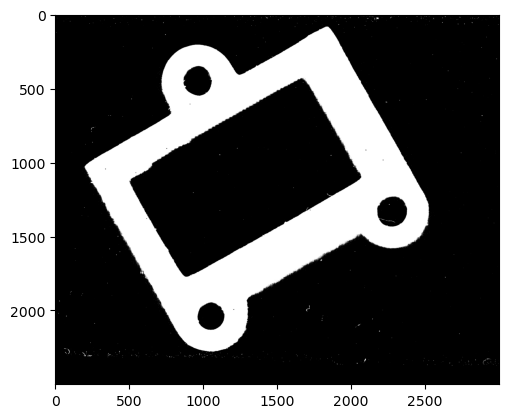

In [17]:
print(blob.shape)
blob_for_plot = np.moveaxis(blob[0,:,:,:], 0,2)
print(blob_for_plot.shape)
blob_for_plot = cv2.cvtColor(blob_for_plot, cv2.COLOR_BGR2RGB)
plt.imshow(blob_for_plot)

In [4]:
import cv2
from matplotlib import pyplot as plt
import numpy as np


# There is a Crop layer that the HED network uses which is not implemented by 
# default so we need to provide our own implementation of this layer.
#Without the crop layer, the final result will be shifted to the right and bottom
#cropping part of the image
class CropLayer(object):
    def __init__(self, params, blobs):
        # initialize our starting and ending (x, y)-coordinates of
        # the crop
        self.startX = 0
        self.startY = 0
        self.endX = 0
        self.endY = 0

    def getMemoryShapes(self, inputs):
        # the crop layer will receive two inputs -- we need to crop
        # the first input blob to match the shape of the second one,
        # keeping the batch size and number of channels
        (inputShape, targetShape) = (inputs[0], inputs[1])
        (batchSize, numChannels) = (inputShape[0], inputShape[1])
        (H, W) = (targetShape[2], targetShape[3])

        # compute the starting and ending crop coordinates
        self.startX = int((inputShape[3] - targetShape[3]) / 2)
        self.startY = int((inputShape[2] - targetShape[2]) / 2)
        self.endX = self.startX + W
        self.endY = self.startY + H

        # return the shape of the volume (we'll perform the actual
        # crop during the forward pass
        return [[batchSize, numChannels, H, W]]

    def forward(self, inputs):
        # use the derived (x, y)-coordinates to perform the crop
        return [inputs[0][:, :, self.startY:self.endY,
                self.startX:self.endX]]

In [5]:
protoPath = r"C:\Users\Navdeep\Downloads\deploy.prototxt"
modelPath = r"C:\Users\Navdeep\Downloads\hed_pretrained_bsds.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
cv2.dnn_registerLayer("Crop", CropLayer)

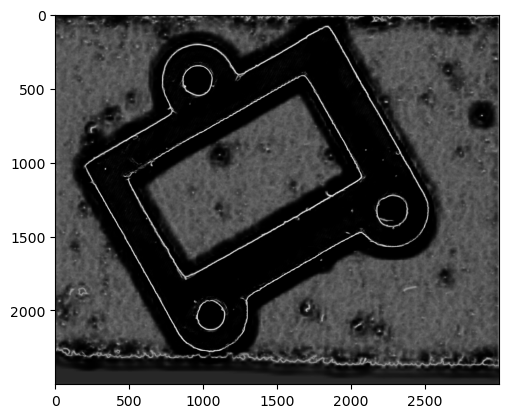

In [6]:
net.setInput(filtered_transposed)
hed = net.forward()

hed = hed[0,0,:,:]  #Drop the other axes 
#hed = cv2.resize(hed[0, 0], (W, H))
hed = (255 * hed).astype("uint8")  #rescale to 0-255

plt.imshow(hed, cmap='gray')


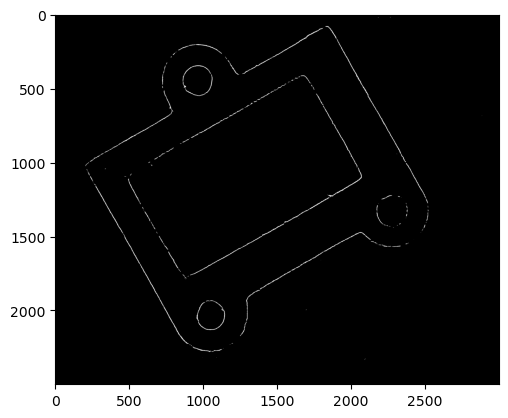

In [19]:
_, binary_hed = cv2.threshold(hed, 200, 255, cv2.THRESH_BINARY)
plt.imshow(binary_hed , cmap = 'gray')

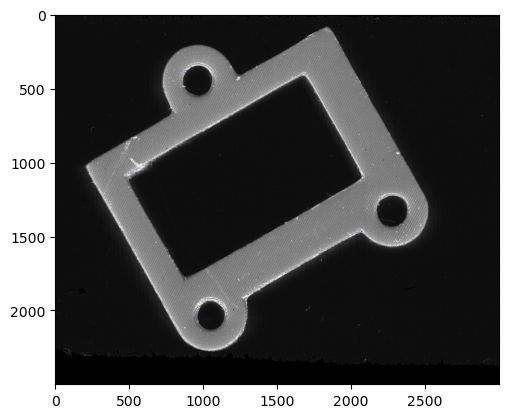

In [10]:
hed_float = np.float32(hed)

# Apply Harris Corner Detection
block_size = 2
aperture_size = 3
k = 0.04
dst = cv2.cornerHarris(hed_float, block_size, aperture_size, k)

# Result is dilated for marking the corners, not important
dst = cv2.dilate(dst, None)

# Threshold for an optimal value, it may vary depending on the image
image[dst > 0.01 * dst.max()] = [0, 0, 255]


plt.imshow(image)

In [22]:
import numpy as np
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# contour_image = np.zeros_like(gray_image)
# cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 1)
# plt.imshow(contour_image, cmap='gray')

In [24]:
import os
output_dir = r'C:\Part_dimensions'
for i, contour in enumerate(contours):
        contour_image = np.zeros_like(gray_image)
        cv2.drawContours(contour_image, [contour], -1, (255, 255, 255), 1)
        output_path = os.path.join(output_dir, f'contour_{i+1}.png')
        cv2.imwrite(output_path, contour_image)

#         plt.imshow(contour_image, cmap='gray')
#         plt.title(f'Contour {i+1}')
#         plt.show()

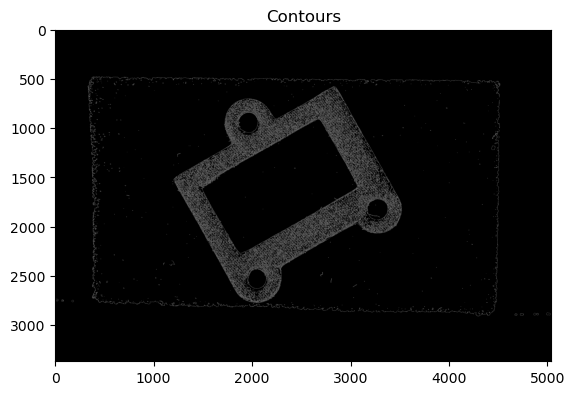

Rectangle detected at (4750, 2894) with width 12 and height 14
Rectangle detected at (4726, 2890) with width 16 and height 19
Rectangle detected at (4670, 2887) with width 27 and height 23
Rectangle detected at (4893, 2884) with width 22 and height 21
Rectangle detected at (4862, 2883) with width 27 and height 23
Rectangle detected at (4992, 2879) with width 45 and height 26
Rectangle detected at (4301, 2879) with width 13 and height 11
Rectangle detected at (4321, 2878) with width 78 and height 26
Rectangle detected at (4271, 2874) with width 16 and height 36
Rectangle detected at (4209, 2870) with width 47 and height 25
Rectangle detected at (3426, 2862) with width 51 and height 15
Rectangle detected at (3667, 2861) with width 112 and height 14
Rectangle detected at (3478, 2861) with width 31 and height 13
Rectangle detected at (2990, 2860) with width 52 and height 11
Rectangle detected at (4060, 2859) with width 142 and height 29
Rectangle detected at (3944, 2858) with width 93 and 

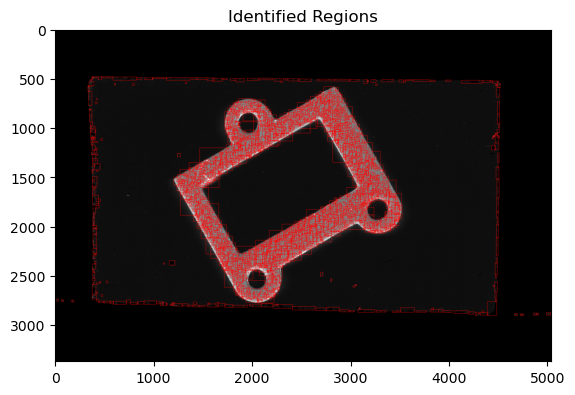

In [28]:
# #GPT code



# # Load and preprocess the image
# image_path = r"C:\Users\Navdeep\Downloads\squared_and_circular_object.tif"
# image1 = cv2.imread(image_path)

# image2 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

# # Detect edges using Canny edge detector
# edges = cv2.Canny(image2, 50, 150)

# # Find contours
# contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # Draw contours and analyze them
# contour_image = np.zeros_like(image)
# cv2.drawContours(contour_image, contours, -1, (255, 255, 255), 1)

# # Display contours
# plt.imshow(contour_image, cmap='gray')
# plt.title('Contours')
# plt.show()

# for contour in contours:
#     # Approximate the contour to a polygon
#     epsilon = 0.01 * cv2.arcLength(contour, True)
#     approx = cv2.approxPolyDP(contour, epsilon, True)

# #     # Measure thickness for parallel edges (approximated as lines)
# #     if len(approx) >= 4:
# #         for i in range(len(approx)):
# #             pt1 = approx[i][0]
# #             pt2 = approx[(i+1) % len(approx)][0]
# #             pt3 = approx[(i+2) % len(approx)][0]
# #             pt4 = approx[(i+3) % len(approx)][0]
            
# #             # Calculate distances between parallel edges
# #             if pt1[0] == pt2[0] and pt3[0] == pt4[0]:  # Vertical lines
# #                 thickness = abs(pt1[0] - pt3[0])
# #                 print(f"Thickness between parallel vertical edges: {thickness}")
# #             elif pt1[1] == pt2[1] and pt3[1] == pt4[1]:  # Horizontal lines
# #                 thickness = abs(pt1[1] - pt3[1])
# #                 print(f"Thickness between parallel horizontal edges: {thickness}")
    
# #     # Identify circular regions
# #     (x, y), radius = cv2.minEnclosingCircle(contour)
# #     center = (int(x), int(y))
# #     radius = int(radius)
# #     if radius > 10:  # Threshold radius to identify circular regions
# #         cv2.circle(contour_image, center, radius, (255, 0, 0), 2)
# #         print(f"Circle detected at {center} with radius {radius}")

#     # Identify rectangular-like regions
#     x, y, w, h = cv2.boundingRect(contour)
#     if w > 10 and h > 10:  # Threshold dimensions to identify rectangular regions
#         cv2.rectangle(image1, (x, y), (x + w, y + h), (255, 0, 0), 2)
#         print(f"Rectangle detected at ({x}, {y}) with width {w} and height {h}")

# # Display the identified regions
# plt.imshow(image1)
# plt.title('Identified Regions')
# plt.show()


In [74]:
#experiments with kernels 

import cv2
import os
import numpy as np
from PIL import Image


image_path = r"C:\Part_dimensions_project\cropped.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
temp = cv2.imread(r"C:\Part_dimensions_project\cropped_4.png" , cv2.IMREAD_GRAYSCALE)
kernel_size = (500, 500)  # size of the kernel
stride = 5
output_dir = r"C:\Part_dimensions_project\Part_dimensions_6"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get the dimensions of the image
height, width = image.shape

# Initialize a counter for saved images
counter = 0

# Slide the kernel across the image
for y in range(0, height - kernel_size[1] + 1, stride):
    for x in range(0, width - kernel_size[0] + 1, stride):
        # Extract the sub-image
#         sub_image = temp[y:y + kernel_size[1], x:x + kernel_size[0]]
        if (y + kernel_size[1]) <= 1250 :
            print('y')
            print(y)
            print('x')
            print(x)
#         unique_elements = np.unique(sub_image)
#         if(len(unique_elements) > 1 ):
# #             print(len(unique_elements))
# #             print('here')
#             sub_image_2 = image[y:y + kernel_size[1], x:x + kernel_size[0]]
#             # Save the sub-image
#             sub_image_path = os.path.join(output_dir, f'sub_image_{counter}.png')
#             cv2.imwrite(sub_image_path, sub_image_2)
#             counter += 1

# print(f'Total sub-images saved: {counter}')


y
0
x
0
y
0
x
5
y
0
x
10
y
0
x
15
y
0
x
20
y
0
x
25
y
0
x
30
y
0
x
35
y
0
x
40
y
0
x
45
y
0
x
50
y
0
x
55
y
0
x
60
y
0
x
65
y
0
x
70
y
0
x
75
y
0
x
80
y
0
x
85
y
0
x
90
y
0
x
95
y
0
x
100
y
0
x
105
y
0
x
110
y
0
x
115
y
0
x
120
y
0
x
125
y
0
x
130
y
0
x
135
y
0
x
140
y
0
x
145
y
0
x
150
y
0
x
155
y
0
x
160
y
0
x
165
y
0
x
170
y
0
x
175
y
0
x
180
y
0
x
185
y
0
x
190
y
0
x
195
y
0
x
200
y
0
x
205
y
0
x
210
y
0
x
215
y
0
x
220
y
0
x
225
y
0
x
230
y
0
x
235
y
0
x
240
y
0
x
245
y
0
x
250
y
0
x
255
y
0
x
260
y
0
x
265
y
0
x
270
y
0
x
275
y
0
x
280
y
0
x
285
y
0
x
290
y
0
x
295
y
0
x
300
y
0
x
305
y
0
x
310
y
0
x
315
y
0
x
320
y
0
x
325
y
0
x
330
y
0
x
335
y
0
x
340
y
0
x
345
y
0
x
350
y
0
x
355
y
0
x
360
y
0
x
365
y
0
x
370
y
0
x
375
y
0
x
380
y
0
x
385
y
0
x
390
y
0
x
395
y
0
x
400
y
0
x
405
y
0
x
410
y
0
x
415
y
0
x
420
y
0
x
425
y
0
x
430
y
0
x
435
y
0
x
440
y
0
x
445
y
0
x
450
y
0
x
455
y
0
x
460
y
0
x
465
y
0
x
470
y
0
x
475
y
0
x
480
y
0
x
485
y
0
x
490
y
0
x
495
y
0
x
500
y
0
x
505
y


x
1100
y
195
x
1105
y
195
x
1110
y
195
x
1115
y
195
x
1120
y
195
x
1125
y
195
x
1130
y
195
x
1135
y
195
x
1140
y
195
x
1145
y
195
x
1150
y
195
x
1155
y
195
x
1160
y
195
x
1165
y
195
x
1170
y
195
x
1175
y
195
x
1180
y
195
x
1185
y
195
x
1190
y
195
x
1195
y
195
x
1200
y
195
x
1205
y
195
x
1210
y
195
x
1215
y
195
x
1220
y
195
x
1225
y
195
x
1230
y
195
x
1235
y
195
x
1240
y
195
x
1245
y
195
x
1250
y
195
x
1255
y
195
x
1260
y
195
x
1265
y
195
x
1270
y
195
x
1275
y
195
x
1280
y
195
x
1285
y
195
x
1290
y
195
x
1295
y
195
x
1300
y
195
x
1305
y
195
x
1310
y
195
x
1315
y
195
x
1320
y
195
x
1325
y
195
x
1330
y
195
x
1335
y
195
x
1340
y
195
x
1345
y
195
x
1350
y
195
x
1355
y
195
x
1360
y
195
x
1365
y
195
x
1370
y
195
x
1375
y
195
x
1380
y
195
x
1385
y
195
x
1390
y
195
x
1395
y
195
x
1400
y
195
x
1405
y
195
x
1410
y
195
x
1415
y
195
x
1420
y
195
x
1425
y
195
x
1430
y
195
x
1435
y
195
x
1440
y
195
x
1445
y
195
x
1450
y
195
x
1455
y
195
x
1460
y
195
x
1465
y
195
x
1470
y
195
x
1475
y
195
x
1480
y
195

x
1945
y
415
x
1950
y
415
x
1955
y
415
x
1960
y
415
x
1965
y
415
x
1970
y
415
x
1975
y
415
x
1980
y
415
x
1985
y
415
x
1990
y
415
x
1995
y
415
x
2000
y
415
x
2005
y
415
x
2010
y
415
x
2015
y
415
x
2020
y
415
x
2025
y
415
x
2030
y
415
x
2035
y
415
x
2040
y
415
x
2045
y
415
x
2050
y
415
x
2055
y
415
x
2060
y
415
x
2065
y
415
x
2070
y
415
x
2075
y
415
x
2080
y
415
x
2085
y
415
x
2090
y
415
x
2095
y
415
x
2100
y
415
x
2105
y
415
x
2110
y
415
x
2115
y
415
x
2120
y
415
x
2125
y
415
x
2130
y
415
x
2135
y
415
x
2140
y
415
x
2145
y
415
x
2150
y
415
x
2155
y
415
x
2160
y
415
x
2165
y
415
x
2170
y
415
x
2175
y
415
x
2180
y
415
x
2185
y
415
x
2190
y
415
x
2195
y
415
x
2200
y
415
x
2205
y
415
x
2210
y
415
x
2215
y
415
x
2220
y
415
x
2225
y
415
x
2230
y
415
x
2235
y
415
x
2240
y
415
x
2245
y
415
x
2250
y
415
x
2255
y
415
x
2260
y
415
x
2265
y
415
x
2270
y
415
x
2275
y
415
x
2280
y
415
x
2285
y
415
x
2290
y
415
x
2295
y
415
x
2300
y
415
x
2305
y
415
x
2310
y
415
x
2315
y
415
x
2320
y
415
x
2325
y
415

655
x
515
y
655
x
520
y
655
x
525
y
655
x
530
y
655
x
535
y
655
x
540
y
655
x
545
y
655
x
550
y
655
x
555
y
655
x
560
y
655
x
565
y
655
x
570
y
655
x
575
y
655
x
580
y
655
x
585
y
655
x
590
y
655
x
595
y
655
x
600
y
655
x
605
y
655
x
610
y
655
x
615
y
655
x
620
y
655
x
625
y
655
x
630
y
655
x
635
y
655
x
640
y
655
x
645
y
655
x
650
y
655
x
655
y
655
x
660
y
655
x
665
y
655
x
670
y
655
x
675
y
655
x
680
y
655
x
685
y
655
x
690
y
655
x
695
y
655
x
700
y
655
x
705
y
655
x
710
y
655
x
715
y
655
x
720
y
655
x
725
y
655
x
730
y
655
x
735
y
655
x
740
y
655
x
745
y
655
x
750
y
655
x
755
y
655
x
760
y
655
x
765
y
655
x
770
y
655
x
775
y
655
x
780
y
655
x
785
y
655
x
790
y
655
x
795
y
655
x
800
y
655
x
805
y
655
x
810
y
655
x
815
y
655
x
820
y
655
x
825
y
655
x
830
y
655
x
835
y
655
x
840
y
655
x
845
y
655
x
850
y
655
x
855
y
655
x
860
y
655
x
865
y
655
x
870
y
655
x
875
y
655
x
880
y
655
x
885
y
655
x
890
y
655
x
895
y
655
x
900
y
655
x
905
y
655
x
910
y
655
x
915
y
655
x
920
y
655
x
925
y
655


In [1]:
import ultralytics

print("Ultralytics version:", ultralytics.__version__)

Ultralytics version: 8.1.0


In [9]:
#sorted_dict = {k: input_dict[k] for k in sorted(input_dict, reverse=True)}
import cv2
import os
import numpy as np
from PIL import Image
image_path = r"C:\Part_dimensions_project\cropped.jpg"
image_path_2 = r"C:\Part_dimensions_project\data_collection.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
checking_image = cv2.imread(image_path_2, cv2.IMREAD_GRAYSCALE)

kernel_size = (500, 500)  # size of the kernel
stride = 5

h, w = image.shape
# print(height , width)
counter_A1 = 0
counter_A2 = 0
counter_A3 = 0
counter_A4 = 0 

output_dir_1 = r'C:\Part_dimensions_project\Area_1'
output_dir_2 = r'C:\Part_dimensions_project\Area_2'
output_dir_3 = r'C:\Part_dimensions_project\Area_3'
output_dir_4 = r'C:\Part_dimensions_project\Area_4'


for y in range(0 , h - kernel_size[1] + 1, stride):
    for x in range(0 , w - kernel_size[0] + 1, stride):
        in_y_range = y <= 1250 < y + kernel_size[1]
        in_x_range = x <= 1500 < x + kernel_size[0]
#         print(y + kernel_size[1])
#         if (y + kernel_size[1]) <= 1250 :
#             print('y')
#             print(y)
#             print('x')
#             print(x)
        if (in_x_range == True) and (in_y_range == False) and (y + kernel_size[1] <= 1250):
#             print('here 1')
            x1 , y1 = x , y
            x2 , y2 = 1500 , y + kernel_size[1]
            width = abs(x2 - x1)
            height = abs(y2 - y1)
            
            Area_rect_1 = width * height
            
            x1 , y1 = 1500 , y
            x2 , y2 = x + kernel_size[0] , y + kernel_size[1]
            width = abs(x2 - x1)
            height = abs(y2 - y1)
            
            Area_rect_2 = width * height
            
            if (Area_rect_1 > Area_rect_2):
                sub_image_checking = checking_image[y:y + kernel_size[1], x:x + kernel_size[0]]
                unique_elements = np.unique(sub_image_checking)
#                 print('Area 1')
                if(len(unique_elements) == 1):
                    
                    sub_image = image[y:y + kernel_size[1], x:x + kernel_size[0]]
                    sub_image_path = os.path.join(output_dir_1, f'sub_image_{counter_A1}.png')
                    cv2.imwrite(sub_image_path, sub_image)
                    counter_A1 = counter_A1 + 1
                
            if (Area_rect_1 < Area_rect_2):
                sub_image_checking = checking_image[y:y + kernel_size[1], x:x + kernel_size[0]]
                unique_elements = np.unique(sub_image_checking)
#                 print('Area 2')
                if(len(unique_elements) == 1):
                    
                
                    sub_image = image[y:y+kernel_size[1] , x:x + kernel_size[0]]
                    sub_image_path = os.path.join(output_dir_2, f'sub_image_{counter_A2}.png')
                    cv2.imwrite(sub_image_path, sub_image)
                    counter_A2 = counter_A2 + 1
            
            elif (Area_rect_1 == Area_rect_2):
                sub_image_checking = checking_image[y:y + kernel_size[1], x:x + kernel_size[0]]
                unique_elements = np.unique(sub_image_checking)
#                 print('Area 1 and Area 2')
                if(len(unique_elements) == 1):
                    sub_image = image[y:y+kernel_size[1] , x:x + kernel_size[0]]
                    sub_image_path_1 = os.path.join(output_dir_1, f'sub_image_{counter_A1}_o_2.png')
                    sub_image_path_2 = os.path.join(output_dir_2, f'sub_image_{counter_A2}_o_1.png')
                    cv2.imwrite(sub_image_path_1, sub_image)
                    cv2.imwrite(sub_image_path_2, sub_image)
                    counter_A1 = counter_A1 + 1
                    counter_A2 = counter_A2 + 1
        
#         if(in_x_range == True) and (in_y_range == False) and (y + kernel_size[1] > 1250):
#             print('here 1')
#             x1 , y1 = x , y
#             x2 , y2 = 1500 , y + kernel_size[1]
#             width = abs(x2 - x1)
#             height = abs(y2 - y1)
            
#             Area_rect_1 = width * height
            
#             x1 , y1 = 1500 , y
#             x2 , y2 = x + kernel_size[0] , y + kernel_size[1]
#             width = abs(x2 - x1)
#             height = abs(y2 - y1)
            
#             Area_rect_2 = width * height
            
#             if (Area_rect_1 > Area_rect_2):
#                 sub_image_checking = checking_image[y:y + kernel_size[1], x:x + kernel_size[0]]
#                 unique_elements = np.unique(sub_image_checking)
#                 if(len(unique_elements) == 1):
                    
#                     sub_image = image[y:y + kernel_size[1], x:x + kernel_size[0]]
#                     sub_image_path = os.path.join(output_dir_3, f'sub_image_{counter_A3}.png')
#                     cv2.imwrite(sub_image_path, sub_image)
#                     counter_A3 = counter_A3 + 1
                
#             if (Area_rect_1 < Area_rect_2):
#                 sub_image_checking = checking_image[y:y + kernel_size[1], x:x + kernel_size[0]]
#                 unique_elements = np.unique(sub_image_checking)
#                 if(len(unique_elements) == 1):
#                     sub_image = image[y:y+kernel_size[1] , x:x + kernel_size[0]]
#                     sub_image_path = os.path.join(output_dir_4, f'sub_image_{counter_A4}.png')
#                     cv2.imwrite(sub_image_path, sub_image)
#                     counter_A4 = counter_A4 + 1
            
#             elif (Area_rect_1 == Area_rect_2):
#                 sub_image_checking = checking_image[y:y + kernel_size[1], x:x + kernel_size[0]]
#                 unique_elements = np.unique(sub_image_checking)
#                 if(len(unique_elements) == 1):
#                     sub_image = image[y:y+kernel_size[1] , x:x + kernel_size[0]]
#                     sub_image_path_1 = os.path.join(output_dir_3, f'sub_image_{counter_A3}_o_4.png')
#                     sub_image_path_2 = os.path.join(output_dir_4, f'sub_image_{counter_A4}_o_3.png')
#                     cv2.imwrite(sub_image_path_1, sub_image)
#                     cv2.imwrite(sub_image_path_2, sub_image)
#                     counter_A3 = counter_A3 + 1
#                     counter_A4 = counter_A4 + 1
            
        
#         if (in_x_range == False) and (in_y_range == True) and (x + kernel_size[0] <= 1500):
# #             print('here 2')
#             x1 , y1 = x , y
#             x2 , y2 = x + kernel_size[0] , 1250
#             width = abs(x2 - x1)
#             height = abs(y2 - y1)
            
#             Area_rect_1 = width * height
            
#             x1 , y1 = x , 1250
#             x2 , y2 = x + kernel_size[0] , y + kernel_size[1]
#             width = abs(x2 - x1)
#             height = abs(y2 - y1)
            
#             Area_rect_2 = width * height
            
#             if (Area_rect_1 > Area_rect_2):
#                 sub_image_checking = checking_image[y:y + kernel_size[1], x:x + kernel_size[0]]
#                 unique_elements = np.unique(sub_image_checking)
#                 if(len(unique_elements) == 1):
#                     sub_image = image[y:y + kernel_size[1], x:x + kernel_size[0]]
#                     sub_image_path = os.path.join(output_dir_1, f'sub_image_{counter_A1}.png')
#                     cv2.imwrite(sub_image_path, sub_image)
#                     counter_A1 = counter_A1 + 1

#             if (Area_rect_1 < Area_rect_2):
#                 sub_image_checking = checking_image[y:y + kernel_size[1], x:x + kernel_size[0]]
#                 unique_elements = np.unique(sub_image_checking)
#                 if(len(unique_elements) == 1):
                    
#                     sub_image = image[y:y+kernel_size[1] , x:x + kernel_size[0]]
#                     sub_image_path = os.path.join(output_dir_3, f'sub_image_{counter_A3}.png')
#                     cv2.imwrite(sub_image_path, sub_image)
#                     counter_A3 = counter_A3 + 1
            
#             elif (Area_rect_1 == Area_rect_2):
#                 sub_image_checking = checking_image[y:y + kernel_size[1], x:x + kernel_size[0]]
#                 unique_elements = np.unique(sub_image_checking)
#                 if(len(unique_elements) == 1):
                    
#                     sub_image = image[y:y+kernel_size[1] , x:x + kernel_size[0]]
#                     sub_image_path_1 = os.path.join(output_dir_1, f'sub_image_{counter_A1}_o_3.png')
#                     sub_image_path_2 = os.path.join(output_dir_3, f'sub_image_{counter_A3}_o_1.png')
#                     cv2.imwrite(sub_image_path_1, sub_image)
#                     cv2.imwrite(sub_image_path_2, sub_image)
#                     counter_A1 = counter_A1 + 1
#                     counter_A3 = counter_A3 + 1
                
#         if (in_x_range == False) and (in_y_range == True) and (x + kernel_size[0] > 1500):
# #             print('here 3')
#             x1 , y1 = x , y
#             x2 , y2 = x + kernel_size[0] , 1250
#             width = abs(x2 - x1)
#             height = abs(y2 - y1)
            
#             Area_rect_1 = width * height
            
#             x1 , y1 = x , 1250
#             x2 , y2 = x + kernel_size[0] , y + kernel_size[1]
#             width = abs(x2 - x1)
#             height = abs(y2 - y1)
            
#             Area_rect_2 = width * height
            
#             if (Area_rect_1 > Area_rect_2):
#                 sub_image_checking = checking_image[y:y + kernel_size[1], x:x + kernel_size[0]]
#                 unique_elements = np.unique(sub_image_checking)
#                 if(len(unique_elements) == 1):
#                     sub_image = image[y:y + kernel_size[1], x:x + kernel_size[0]]
#                     sub_image_path = os.path.join(output_dir_2, f'sub_image_{counter_A2}.png')
#                     cv2.imwrite(sub_image_path, sub_image)
#                     counter_A2 = counter_A2 + 1
                
#             if (Area_rect_1 < Area_rect_2):
#                 sub_image_checking = checking_image[y:y + kernel_size[1], x:x + kernel_size[0]]
#                 unique_elements = np.unique(sub_image_checking)
#                 if(len(unique_elements) == 1):
#                     sub_image = image[y:y+kernel_size[1] , x:x + kernel_size[0]]
#                     sub_image_path = os.path.join(output_dir_4, f'sub_image_{counter_A4}.png')
#                     cv2.imwrite(sub_image_path, sub_image)
#                     counter_A4 = counter_A4 + 1
            
#             elif (Area_rect_1 == Area_rect_2):
#                 sub_image_checking = checking_image[y:y + kernel_size[1], x:x + kernel_size[0]]
#                 unique_elements = np.unique(sub_image_checking)
#                 if(len(unique_elements)):
#                     sub_image = image[y:y+kernel_size[1] , x:x + kernel_size[0]]
#                     sub_image_path_1 = os.path.join(output_dir_2, f'sub_image_{counter_A2}_o_4.png')
#                     sub_image_path_2 = os.path.join(output_dir_4, f'sub_image_{counter_A4}_o_2.png')
#                     cv2.imwrite(sub_image_path_1, sub_image)
#                     cv2.imwrite(sub_image_path_2, sub_image)
#                     counter_A2 = counter_A2 + 1
#                     counter_A4 = counter_A4 + 1
            
#         if(in_x_range == True) and (in_y_range == True):
# #             print('here 4')
#             sub_image = image[y:y+kernel_size[1] , x:x + kernel_size[0]]
#             sub_image_checking = checking_image[y:y + kernel_size[1], x:x + kernel_size[0]]
#             unique_elements = np.unique(sub_image_checking)
#             if(len(unique_elements) == 1):
                
#                 x1 , y1 = x , y
#                 x2 , y2 = 1500 , 1250
#                 width = abs(x2 - x1)
#                 height = abs(y2 - y1)

#                 Area_rect_1 = width * height

#                 x1 , y1 = 1500 , y
#                 x2 , y2 = x + kernel_size[0] , 1250
#                 width = abs(x2 - x1)
#                 height = abs(y2 - y1)

#                 Area_rect_2 = width * height

#                 x1 , y1 = x , 1250
#                 x2 , y2 = 1500 , y + kernel_size[1]
#                 width = abs(x2 - x1)
#                 height = abs(y2 - y1)

#                 Area_rect_3 = width * height

#                 x1 , y1 = 1500 , 1250
#                 x2 , y2 = x + kernel_size[0] , y + kernel_size[1]
#                 width = abs(x2 - x1)
#                 height = abs(y2 - y1)

#                 Area_rect_4 = width * height
#                 a_list = [(Area_rect_1 , '1') , (Area_rect_2 , '2') , (Area_rect_3 , '3') , (Area_rect_4 , '4')]
#                 a_list = sorted(a_list, key=lambda x: x[0])

#                 largest_area = sorted_areas_regions[-1][0]

#                 # Collect all tuples with the largest area value
#                 largest_area_regions = [tup for tup in sorted_areas_regions if tup[0] == largest_area]
#                 if (len(largest_area_regions) == 1):
#                     tup = largest_area_regions[0]
#                     region = tup[1]
#                     if (region == '1'):
#                             sub_image_path = os.path.join(output_dir_1, f'sub_image_{counter_A1}.png')
#                             cv2.imwrite(sub_image_path , sub_image)
#                             counter_A1 = counter_A1 + counter_A1
#                     elif(region == '2'):
#                             sub_image_path = os.path.join(output_dir_2, f'sub_image_{counter_A2}.png')
#                             cv2.imwrite(sub_image_path , sub_image)
#                             counter_A2 = counter_A2 + counter_A2
#                     elif(region == '3'):
#                             sub_image_path = os.path.join(output_dir_3, f'sub_image_{counter_A3}.png')
#                             cv2.imwrite(sub_image_path , sub_image)
#                             counter_A3 = counter_A3 + counter_A3
#                     elif(region == '4'):
#                             sub_image_path = os.path.join(output_dir_4, f'sub_image_{counter_A4}.png')
#                             cv2.imwrite(sub_image_path , sub_image)
#                             counter_A4 = counter_A4 + counter_A4
#                 elif (len(largest_area_regions) > 1):
#                     for i in range(largest_area_regions):
#                         string = '_o_'
#                         tup = largest_area_regions[i]
#                         region = tup[1]
#                         for j in range(largest_area_regions):
#                             if(j != i):
#                                 tup = largest_area_regions[j]
#                                 region_1 = tup[1]
#                                 string = string + region_1
#                                 string = string + '_'
#                         string = string + '.png'
#                         if (region == '1'):
#                                 name = f'sub_image_{counter_A1}' + string
#                                 sub_image_path = os.path.join(output_dir_1 , name)
#                                 cv2.imwrite(sub_image_path , sub_image)
#                                 counter_A1 = counter_A1 + 1
#                         elif (region == '2'):
#                                 name = f'sub_image_{counter_A2}' + string
#                                 sub_image_path = os.path.join(output_dir_2 , name)
#                                 cv2.imwrite(sub_image_path , sub_image)
#                                 counter_A2 = counter_A2 + 1
#                         elif (region == '3'):
#                                 name = f'sub_image_{counter_A3}' + string
#                                 sub_image_path = os.path.join(output_dir_3 , name)
#                                 cv2.imwrite(sub_image_path , sub_image)
#                                 counter_A3 = counter_A3 + 1
#                         elif (region == '4'):
#                                 name = f'sub_image_{counter_A4}' + string
#                                 sub_image_path = os.path.join(output_dir_4 , name)
#                                 cv2.imwrite(sub_image_path , sub_image)
#                                 counter_A4 = counter_A4 + 1 

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
1
NVIDIA GeForce RTX 3060 Laptop GPU


In [56]:
import os
import glob

def get_image_paths(folder_path, extensions=[".jpg", ".jpeg", ".png", ".bmp", ".tiff"]):
    image_paths = []
    for ext in extensions:
        image_paths.extend(glob.glob(os.path.join(folder_path, f"*{ext}")))
    return image_paths

# Example usage
folder_path = r"C:\Users\Navdeep\Downloads\ground_truth_3-20240702T210453Z-001\ground_truth_3"
image_paths = get_image_paths(folder_path)

# for path in image_paths:
#     print(path)


In [57]:
print(len(image_paths))

1057


In [58]:
import random

def train_val_test_split(image_paths, train_size=0.8, val_size=0.1, test_size=0.1, seed=None):
    if seed is not None:
        random.seed(seed)  # For reproducibility
    
    random.shuffle(image_paths)  # Shuffle the paths randomly

    assert train_size + val_size + test_size == 1.0, "The sum of train, validation, and test sizes must be 1.0"

    train_split_index = int(len(image_paths) * train_size)
    val_split_index = int(len(image_paths) * (train_size + val_size))

    train_paths = image_paths[:train_split_index]
    val_paths = image_paths[train_split_index:val_split_index]
    test_paths = image_paths[val_split_index:]

    return train_paths, val_paths, test_paths


train_paths , val_paths, test_paths = train_val_test_split(image_paths)

In [64]:
import shutil
destination_folder = r"C:\Part_dimensions_project\object_classification\val\low_thickness"

for path in val_paths:
        image_name = os.path.basename(path)
        destination_path = os.path.join(destination_folder, image_name)
        shutil.copy(path, destination_path)



In [59]:
print(len(train_paths))

845


In [60]:
print(len(test_paths))

106


In [61]:
print(len(val_paths))

106


In [1]:
# results = model.train(
#     data=r"C:\Part_dimensions_project\object_classification",
#     epochs=100,
#     imgsz=500,
#     device='0',
#     patience=5,  # Number of epochs with no improvement after which training will be stopped
#     save=True   # Save the final model after training completes
# )

from ultralytics import YOLO

weights_path = r"C:\Users\Navdeep\runs\classify\train7\weights\last.pt"

model = YOLO(weights_path)

results = model.train(data=r"C:\Part_dimensions_project\object_classification", resume=True , patience = 5)

New https://pypi.org/project/ultralytics/8.2.48 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.0 🚀 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=classify, mode=train, model=C:\Users\Navdeep\runs\classify\train7\weights\last.pt, data=C:\Part_dimensions_project\object_classification, epochs=100, time=None, patience=5, batch=16, imgsz=512, save=True, save_period=1, cache=False, device=0, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False,

train: Scanning C:\Part_dimensions_project\object_classification\train... 2487 images, 0 corrupt: 100%|██████████| 2487
val: Scanning C:\Part_dimensions_project\object_classification\val... 311 images, 0 corrupt: 100%|██████████| 311/311 [


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
Resuming training from C:\Users\Navdeep\runs\classify\train7\weights\last.pt from epoch 13 to 100 total epochs
100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


     13/100      6.46G   0.001436          7        512: 100%|██████████| 156/156 [01:45<00:00,  1.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     14/100      6.56G     0.0312          7        512: 100%|██████████| 156/156 [03:04<00:00,  1.18s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:30<00:00,  3.06s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     15/100      6.46G   0.007384          7        512: 100%|██████████| 156/156 [03:20<00:00,  1.28s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     16/100      6.45G    0.01006          7        512: 100%|██████████| 156/156 [04:01<00:00,  1.55s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     17/100      6.45G    0.01045          7        512: 100%|██████████| 156/156 [07:38<00:00,  2.94s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100      6.44G    0.01834          7        512: 100%|██████████| 156/156 [02:54<00:00,  1.12s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:32<00:00,  3.28s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     19/100      6.46G   0.008213          7        512: 100%|██████████| 156/156 [07:58<00:00,  3.07s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100      6.45G   0.003522          7        512: 100%|██████████| 156/156 [03:54<00:00,  1.50s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:29<00:00,  2.92s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     21/100      6.46G   0.001834          7        512: 100%|██████████| 156/156 [07:11<00:00,  2.77s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     22/100      6.46G   0.001577          7        512: 100%|██████████| 156/156 [04:01<00:00,  1.55s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     23/100      6.46G   0.004878          7        512: 100%|██████████| 156/156 [04:00<00:00,  1.54s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     24/100      6.48G   0.001929          7        512: 100%|██████████| 156/156 [01:48<00:00,  1.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:23<00:00,  2.34s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     25/100      6.46G   0.002186          7        512: 100%|██████████| 156/156 [04:25<00:00,  1.70s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     26/100      6.49G   0.007546          7        512: 100%|██████████| 156/156 [03:19<00:00,  1.28s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:29<00:00,  2.92s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     27/100      6.46G  0.0004086          7        512: 100%|██████████| 156/156 [04:58<00:00,  1.91s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     28/100      6.49G   0.001857          7        512: 100%|██████████| 156/156 [01:58<00:00,  1.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:29<00:00,  3.00s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     29/100      6.46G  0.0006891          7        512: 100%|██████████| 156/156 [07:03<00:00,  2.71s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     30/100      6.48G  0.0002449          7        512: 100%|██████████| 156/156 [03:02<00:00,  1.17s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:38<00:00,  3.83s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     31/100      6.46G    0.00104          7        512: 100%|██████████| 156/156 [06:52<00:00,  2.64s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     32/100      6.48G   0.001026          7        512: 100%|██████████| 156/156 [02:42<00:00,  1.04s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:38<00:00,  3.83s/it]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     33/100      6.46G   0.003101         16        512:  17%|█▋        | 26/156 [01:06<05:31,  2.55s/it]


KeyboardInterrupt: 

In [2]:
#"C:\Part_dimensions_project\object_classification\test"

from ultralytics import YOLO

model = YOLO(r"C:\Users\Navdeep\runs\classify\train7\weights\last.pt")

# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.top1  # top1 accuracy
metrics.top5  # top5 accuracy
probs = result.probs

Ultralytics YOLOv8.1.0 🚀 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8x-cls summary (fused): 133 layers, 56127043 parameters, 0 gradients, 153.8 GFLOPs
train: C:\Part_dimensions_project\object_classification\train... found 2487 images in 3 classes ✅ 
val: C:\Part_dimensions_project\object_classification\val... found 311 images in 3 classes ✅ 
test: C:\Part_dimensions_project\object_classification\test... found 312 images in 3 classes ✅ 


val: Scanning C:\Part_dimensions_project\object_classification\val... 311 images, 0 corrupt: 100%|██████████| 311/311 [
               classes   top1_acc   top5_acc: 100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


                   all          1          1
Speed: 1.1ms preprocess, 14.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val2


1.0

In [33]:
import cv2
# Predict with the model

image_path = r"C:\Part_dimensions_project\object_classification\test\high_thickness\sub_image_12105.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
results = model.predict(image, save=False, imgsz=500, conf=0.5)

result = results[0]

prob_tensor = result.probs.data

for i in range(len(prob_tensor)):
        prob = prob_tensor[i]
#       if (prob > 0.7):
        
        value = round(prob.item())
        
        print(value)


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 216.9ms
Speed: 11.9ms preprocess, 216.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)
1
0
0


In [25]:
import cv2
import os
import numpy as np
from PIL import Image


image_path = r"C:\Part_dimensions_project\cropped.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#temp = cv2.imread(r"C:\Part_dimensions_project\cropped_4.png" , cv2.IMREAD_GRAYSCALE)
kernel_size = (500, 500)  # size of the kernel
stride = 5
output_dir = r"C:\Part_dimensions_project\predicted"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get the dimensions of the image
height, width = image.shape

# Initialize a counter for saved images
counter = 0

# Slide the kernel across the image
for y in range(0, height - kernel_size[1] + 1, stride):
    for x in range(0, width - kernel_size[0] + 1, stride):
        # Extract the sub-image
#         sub_image = temp[y:y + kernel_size[1], x:x + kernel_size[0]]
        
#         unique_elements = np.unique(sub_image)
#         if(len(unique_elements) > 1 ):
#             print(len(unique_elements))
#             print('here')
        sub_image = image[y:y + kernel_size[1], x:x + kernel_size[0]]
        
        
        results = model.predict(sub_image, save=False, imgsz=500)
        result = results[0]
        prob_tensor = result.probs.data
        for i in range(len(prob_tensor)):
            prob = prob_tensor[i]
            if (prob.item() >= 0.9):
                sub_image_path = os.path.join(output_dir, f'sub_image_{counter}.png')
                cv2.imwrite(sub_image_path, sub_image)
                counter += 1
                break

# print(f'Total sub-images saved: {counter}')



WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.69, low_thickness 0.30, high_thickness 0.00, 213.6ms
Speed: 13.1ms preprocess, 213.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.72, low_thickness 0.27, high_thickness 0.01, 93.6ms
Speed: 18.4ms preprocess, 93.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.70, low_thickness 0.30, high_thickness 0.01, 19.7ms
Speed: 9.2ms preprocess, 19.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.68, low_thickness 0.31, high_thickness 0.00, 15.5ms
Speed: 7.6ms preprocess, 15.5ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.70, low_thickness 0.29, high_thickness 0.01, 15.2ms
Speed: 8.7ms preprocess, 15.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.74, low_thickness 0.25, high_thickness 0.01, 15.8ms
Speed: 5.0ms preprocess, 15.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.76, low_thickness 0.22, high_thickness 0.02, 14.3ms
Speed: 8.8ms preprocess, 14.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.69, low_thickness 0.30, high_thickness 0.01, 13.5ms
Speed: 9.5ms preprocess, 13.5ms inference, 0.0ms postprocess per image at


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, low_thickness 0.00, high_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, low_thickness 0.00, high_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, low_thickness 0.00, high_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.1ms
Speed: 10.0ms preprocess, 20.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 17.4ms
Speed: 7.1ms preprocess, 17.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 5.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 0.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image a


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 11.9ms
Speed: 10.5ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 17.1ms
Speed: 5.2ms preprocess, 17.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 8.5ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 8.5ms
Speed: 11.6ms preprocess, 8.5ms inference, 0.0ms postprocess per image a


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.90, radial_thickness 0.10, low_thickness 0.00, 18.0ms
Speed: 12.1ms preprocess, 18.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.80, radial_thickness 0.20, low_thickness 0.00, 14.7ms
Speed: 10.3ms preprocess, 14.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.87, radial_thickness 0.13, low_thickness 0.00, 14.8ms
Speed: 4.6ms preprocess, 14.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.91, radial_thickness 0.09, low_thickness 0.00, 17.0ms
Speed: 10.0ms preprocess, 17.0ms inference, 0.0ms postprocess per image


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 20.5ms
Speed: 7.5ms preprocess, 20.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 17.2ms
Speed: 3.5ms preprocess, 17.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 18.5ms
Speed: 10.0ms preprocess, 18.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 17.4ms
Speed: 3.3ms preprocess, 17.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 13.8ms
Speed: 6.6ms preprocess, 13.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 12.0ms
Speed: 9.8ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 9.0ms
Speed: 10.8ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 17.5ms
Speed: 7.7ms preprocess, 17.5ms inference, 0.0ms postprocess per image at 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 20.0ms
Speed: 0.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 10.0ms
Speed: 9.3ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 16.2ms
Speed: 16.1ms preprocess, 16.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 12.4ms
Speed: 10.4ms preprocess, 12.4ms inference, 0.0ms postprocess per image 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 20.0ms
Speed: 0.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 20.0ms
Speed: 0.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 13.5ms
Speed: 10.0ms preprocess, 13.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.99, radial_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.95, low_thickness 0.04, radial_thickness 0.01, 21.7ms
Speed: 4.8ms preprocess, 21.7ms inference, 0.0ms postprocess per image


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.76, low_thickness 0.16, high_thickness 0.07, 15.2ms
Speed: 9.5ms preprocess, 15.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.81, low_thickness 0.12, high_thickness 0.07, 15.0ms
Speed: 9.3ms preprocess, 15.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.83, low_thickness 0.12, high_thickness 0.05, 15.9ms
Speed: 8.4ms preprocess, 15.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.76, low_thickness 0.20, high_thickness 0.04, 9.0ms
Speed: 9.2ms preprocess, 9.0ms inference, 0.0ms postprocess per image at s


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.79, low_thickness 0.19, high_thickness 0.02, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.78, low_thickness 0.20, high_thickness 0.02, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.79, low_thickness 0.18, high_thickness 0.02, 15.8ms
Speed: 14.5ms preprocess, 15.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.75, low_thickness 0.18, high_thickness 0.07, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.71, low_thickness 0.28, high_thickness 0.01, 16.9ms
Speed: 8.7ms preprocess, 16.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.78, low_thickness 0.20, high_thickness 0.02, 10.0ms
Speed: 8.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.76, low_thickness 0.22, high_thickness 0.02, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.77, low_thickness 0.21, high_thickness 0.02, 20.0ms
Speed: 0.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image a


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.70, low_thickness 0.29, high_thickness 0.01, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.69, low_thickness 0.30, high_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.68, low_thickness 0.32, high_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.68, low_thickness 0.32, high_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.92, low_thickness 0.07, high_thickness 0.01, 22.7ms
Speed: 10.0ms preprocess, 22.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.91, low_thickness 0.09, high_thickness 0.00, 19.0ms
Speed: 0.0ms preprocess, 19.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.95, low_thickness 0.04, high_thickness 0.01, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.97, low_thickness 0.03, high_thickness 0.01, 22.6ms
Speed: 0.0ms preprocess, 22.6ms inference, 0.0ms postprocess per image 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 0.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, low_thickness 0.00, high_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, low_thickness 0.00, high_thickness 0.00, 22.9ms
Speed: 10.0ms preprocess, 22.9ms inference, 0.0ms postprocess per image


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 14.8ms
Speed: 11.4ms preprocess, 14.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 15.9ms
Speed: 8.3ms preprocess, 15.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 22.7ms
Speed: 8.1ms preprocess, 22.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.99, high_thickness 0.01, low_thickness 0.00, 10.1ms
Speed: 11.1ms preprocess, 10.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.98, high_thickness 0.02, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.98, high_thickness 0.02, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.97, high_thickness 0.03, low_thickness 0.00, 22.1ms
Speed: 2.5ms preprocess, 22.1ms inference, 0.0ms postprocess per image


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.98, radial_thickness 0.02, low_thickness 0.00, 10.1ms
Speed: 11.7ms preprocess, 10.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.97, radial_thickness 0.03, low_thickness 0.00, 20.2ms
Speed: 10.0ms preprocess, 20.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.97, radial_thickness 0.03, low_thickness 0.00, 10.1ms
Speed: 10.0ms preprocess, 10.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.98, radial_thickness 0.02, low_thickness 0.00, 14.7ms
Speed: 15.7ms preprocess, 14.7ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.99, radial_thickness 0.01, low_thickness 0.00, 10.3ms
Speed: 8.0ms preprocess, 10.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.99, radial_thickness 0.01, low_thickness 0.00, 20.5ms
Speed: 9.0ms preprocess, 20.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.99, radial_thickness 0.01, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.98, radial_thickness 0.02, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 0.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 13.5ms
Speed: 6.0ms preprocess, 13.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 10.1ms
Speed: 10.0ms preprocess, 10.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 18.8ms
Speed: 10.9ms preprocess, 18.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 12.1ms
Speed: 10.0ms preprocess, 12.1ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 16.7ms
Speed: 13.5ms preprocess, 16.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 20.8ms
Speed: 10.0ms preprocess, 20.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 12.0ms
Speed: 20.0ms preprocess, 12.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 9.1ms
Speed: 21.1ms preprocess, 9.1ms inference, 0.0ms postprocess per image 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 10.0ms
Speed: 10.1ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 20.0ms
Speed: 1.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 14.0ms
Speed: 16.0ms preprocess, 14.0ms inference, 0.0ms postprocess per image


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.64, low_thickness 0.20, radial_thickness 0.16, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.82, low_thickness 0.11, radial_thickness 0.07, 20.0ms
Speed: 0.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.56, radial_thickness 0.35, low_thickness 0.09, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.59, radial_thickness 0.29, low_thickness 0.13, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.84, low_thickness 0.12, high_thickness 0.04, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.84, low_thickness 0.14, high_thickness 0.02, 20.0ms
Speed: 5.5ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.81, low_thickness 0.17, high_thickness 0.01, 18.7ms
Speed: 12.1ms preprocess, 18.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.80, low_thickness 0.19, high_thickness 0.02, 8.1ms
Speed: 8.0ms preprocess, 8.1ms inference, 0.0ms postprocess per image at 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.79, low_thickness 0.19, high_thickness 0.02, 16.0ms
Speed: 14.0ms preprocess, 16.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.79, low_thickness 0.17, high_thickness 0.03, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.71, low_thickness 0.28, high_thickness 0.01, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.75, low_thickness 0.23, high_thickness 0.02, 14.0ms
Speed: 10.0ms preprocess, 14.0ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.81, low_thickness 0.17, high_thickness 0.02, 9.0ms
Speed: 5.5ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.76, low_thickness 0.22, high_thickness 0.02, 10.0ms
Speed: 10.4ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.74, low_thickness 0.22, high_thickness 0.04, 20.0ms
Speed: 0.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.77, low_thickness 0.17, high_thickness 0.06, 20.5ms
Speed: 10.0ms preprocess, 20.5ms inference, 0.0ms postprocess per image at


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.73, low_thickness 0.26, high_thickness 0.01, 10.2ms
Speed: 10.0ms preprocess, 10.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.72, low_thickness 0.28, high_thickness 0.01, 13.0ms
Speed: 7.2ms preprocess, 13.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.75, low_thickness 0.25, high_thickness 0.01, 20.3ms
Speed: 3.0ms preprocess, 20.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.71, low_thickness 0.28, high_thickness 0.01, 23.7ms
Speed: 10.0ms preprocess, 23.7ms inference, 0.0ms postprocess per image 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, low_thickness 0.00, high_thickness 0.00, 10.0ms
Speed: 7.5ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.99, low_thickness 0.00, high_thickness 0.00, 10.0ms
Speed: 7.1ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, low_thickness 0.00, high_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, low_thickness 0.00, high_thickness 0.00, 17.5ms
Speed: 12.5ms preprocess, 17.5ms inference, 0.0ms postprocess per image 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, low_thickness 0.00, high_thickness 0.00, 16.9ms
Speed: 11.7ms preprocess, 16.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 1.5ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 9.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.1ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 12.6ms
Speed: 12.0ms preprocess, 12.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 11.3ms
Speed: 10.0ms preprocess, 11.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 13.0ms
Speed: 11.0ms preprocess, 13.0ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.54, high_thickness 0.46, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.55, high_thickness 0.45, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.58, radial_thickness 0.42, low_thickness 0.00, 18.0ms
Speed: 12.5ms preprocess, 18.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.64, radial_thickness 0.36, low_thickness 0.00, 13.6ms
Speed: 12.3ms preprocess, 13.6ms inference, 2.4ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 10.3ms
Speed: 9.0ms preprocess, 10.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.99, radial_thickness 0.01, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.99, radial_thickness 0.01, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.99, radial_thickness 0.01, low_thickness 0.00, 20.0ms
Speed: 0.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 0.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 0.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 3.5ms preprocess, 20.0ms inference, 0.0ms postprocess per image 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 10.0ms
Speed: 20.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 10.5ms
Speed: 10.0ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 10.1ms
Speed: 10.3ms preprocess, 10.1ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 10.0ms
Speed: 20.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 20.0ms
Speed: 7.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 16.2ms
Speed: 14.1ms preprocess, 16.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 10.1ms
Speed: 7.5ms preprocess, 10.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 19.5ms
Speed: 10.0ms preprocess, 19.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.54, low_thickness 0.27, high_thickness 0.19, 9.5ms
Speed: 9.0ms preprocess, 9.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.48, high_thickness 0.37, low_thickness 0.14, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.57, high_thickness 0.23, low_thickness 0.21, 10.0ms
Speed: 9.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.64, high_thickness 0.19, low_thickness 0.17, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.75, low_thickness 0.25, high_thickness 0.01, 10.0ms
Speed: 10.1ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.73, low_thickness 0.27, high_thickness 0.01, 17.5ms
Speed: 10.0ms preprocess, 17.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.78, low_thickness 0.21, high_thickness 0.01, 13.6ms
Speed: 10.0ms preprocess, 13.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.77, low_thickness 0.23, high_thickness 0.01, 10.2ms
Speed: 9.0ms preprocess, 10.2ms inference, 0.0ms postprocess per image


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.77, low_thickness 0.21, high_thickness 0.02, 20.1ms
Speed: 10.0ms preprocess, 20.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.80, low_thickness 0.19, high_thickness 0.02, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.79, low_thickness 0.20, high_thickness 0.02, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.75, low_thickness 0.23, high_thickness 0.01, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.69, low_thickness 0.31, high_thickness 0.00, 20.0ms
Speed: 0.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.71, low_thickness 0.28, high_thickness 0.00, 20.0ms
Speed: 0.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.72, low_thickness 0.28, high_thickness 0.00, 20.1ms
Speed: 10.0ms preprocess, 20.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.72, low_thickness 0.27, high_thickness 0.01, 19.4ms
Speed: 5.6ms preprocess, 19.4ms inference, 0.0ms postprocess per image a


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.79, low_thickness 0.19, high_thickness 0.01, 19.9ms
Speed: 5.0ms preprocess, 19.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.75, low_thickness 0.24, high_thickness 0.01, 11.9ms
Speed: 8.5ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.72, low_thickness 0.27, high_thickness 0.01, 11.4ms
Speed: 8.5ms preprocess, 11.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.76, low_thickness 0.23, high_thickness 0.01, 13.2ms
Speed: 8.7ms preprocess, 13.2ms inference, 0.0ms postprocess per image at


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, low_thickness 0.00, high_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, low_thickness 0.00, high_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, low_thickness 0.00, high_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, low_thickness 0.00, high_thickness 0.00, 20.1ms
Speed: 10.0ms preprocess, 20.1ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 13.0ms
Speed: 10.0ms preprocess, 13.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.1ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 4.8ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 14.3ms
Speed: 6.7ms preprocess, 14.3ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.8ms
Speed: 0.0ms preprocess, 20.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 10.5ms
Speed: 10.0ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 0.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.85, radial_thickness 0.15, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.91, radial_thickness 0.09, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.94, radial_thickness 0.06, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.96, radial_thickness 0.04, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 8.5ms
Speed: 11.5ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 20.2ms
Speed: 10.0ms preprocess, 20.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 17.5ms
Speed: 12.6ms preprocess, 17.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 9.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image a


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 17.0ms
Speed: 10.0ms preprocess, 17.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 19.7ms
Speed: 0.0ms preprocess, 19.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 8.5ms
Speed: 8.6ms preprocess, 8.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 11.2ms
Speed: 6.0ms preprocess, 11.2ms inference, 0.0ms postprocess per image at 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 10.0ms
Speed: 7.5ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.99, radial_thickness 0.01, low_thickness 0.00, 13.5ms
Speed: 10.0ms preprocess, 13.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.99, radial_thickness 0.01, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.72, low_thickness 0.28, high_thickness 0.01, 20.0ms
Speed: 3.5ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.75, low_thickness 0.24, high_thickness 0.01, 19.1ms
Speed: 6.8ms preprocess, 19.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.79, low_thickness 0.20, high_thickness 0.01, 10.0ms
Speed: 8.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.74, low_thickness 0.24, high_thickness 0.01, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image a


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.64, low_thickness 0.35, high_thickness 0.00, 20.0ms
Speed: 0.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.69, low_thickness 0.30, high_thickness 0.01, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.69, low_thickness 0.29, high_thickness 0.02, 20.2ms
Speed: 10.1ms preprocess, 20.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.63, low_thickness 0.36, high_thickness 0.01, 13.8ms
Speed: 8.5ms preprocess, 13.8ms inference, 0.0ms postprocess per image 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.76, low_thickness 0.23, high_thickness 0.01, 18.0ms
Speed: 1.6ms preprocess, 18.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.76, low_thickness 0.23, high_thickness 0.01, 14.2ms
Speed: 16.1ms preprocess, 14.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.75, low_thickness 0.23, high_thickness 0.01, 13.6ms
Speed: 5.0ms preprocess, 13.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.71, low_thickness 0.28, high_thickness 0.01, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.65, low_thickness 0.35, high_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.70, low_thickness 0.30, high_thickness 0.00, 17.5ms
Speed: 10.0ms preprocess, 17.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.69, low_thickness 0.31, high_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.70, low_thickness 0.30, high_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.95, low_thickness 0.04, high_thickness 0.00, 16.5ms
Speed: 14.0ms preprocess, 16.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.96, low_thickness 0.03, high_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.97, low_thickness 0.03, high_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.98, low_thickness 0.02, high_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, low_thickness 0.00, high_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, low_thickness 0.00, high_thickness 0.00, 21.1ms
Speed: 0.0ms preprocess, 21.1ms inference, 0.0ms postprocess per image


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 13.0ms
Speed: 17.0ms preprocess, 13.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 18.5ms
Speed: 4.7ms preprocess, 18.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 18.7ms
Speed: 8.1ms preprocess, 18.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 11.9ms
Speed: 7.5ms preprocess, 11.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 1.00, high_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image a


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.98, high_thickness 0.02, low_thickness 0.00, 15.0ms
Speed: 7.0ms preprocess, 15.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.97, high_thickness 0.03, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.95, high_thickness 0.05, low_thickness 0.00, 20.0ms
Speed: 0.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.93, high_thickness 0.07, low_thickness 0.00, 15.0ms
Speed: 10.0ms preprocess, 15.0ms inference, 0.0ms postprocess per image 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.99, radial_thickness 0.01, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.99, radial_thickness 0.01, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.99, radial_thickness 0.01, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.98, radial_thickness 0.02, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.98, radial_thickness 0.02, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per imag


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 20.0ms
Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 12.5ms
Speed: 10.0ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, radial_thickness 0.00, low_thickness 0.00, 25.1ms
Speed: 8.0ms preprocess, 25.1ms inference, 0.0ms postprocess per image


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 13.6ms
Speed: 10.0ms preprocess, 13.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 20.0ms
Speed: 4.5ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 10.0ms
Speed: 10.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 20.0ms
Speed: 0.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image 


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 8.4ms
Speed: 6.8ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 14.6ms
Speed: 8.1ms preprocess, 14.6ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 14.0ms
Speed: 9.9ms preprocess, 14.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 15.7ms
Speed: 9.0ms preprocess, 15.7ms inference, 0.0ms postprocess per image at s

0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 10.5ms
Speed: 7.1ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 7.9ms
Speed: 14.1ms preprocess, 7.9ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 17.2ms
Speed: 6.3ms preprocess, 17.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 1.00, low_thickness 0.00, radial_thickness 0.00, 15.2ms
Speed: 7.9ms preprocess, 15.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride

Speed: 9.0ms preprocess, 14.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.55, radial_thickness 0.34, low_thickness 0.11, 14.4ms
Speed: 9.8ms preprocess, 14.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.73, radial_thickness 0.22, low_thickness 0.04, 15.1ms
Speed: 9.2ms preprocess, 15.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 high_thickness 0.68, radial_thickness 0.21, low_thickness 0.11, 16.1ms
Speed: 9.2ms preprocess, 16.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.42, high_thickness 0.36, low

Speed: 10.0ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.62, low_thickness 0.38, high_thickness 0.00, 20.2ms
Speed: 10.0ms preprocess, 20.2ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.70, low_thickness 0.30, high_thickness 0.01, 20.0ms
Speed: 8.1ms preprocess, 20.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.71, low_thickness 0.28, high_thickness 0.01, 19.7ms
Speed: 6.6ms preprocess, 19.7ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.68, low_thickness 0.32, hi

Speed: 7.0ms preprocess, 14.7ms inference, 4.5ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.63, low_thickness 0.36, high_thickness 0.00, 11.8ms
Speed: 8.7ms preprocess, 11.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.67, low_thickness 0.33, high_thickness 0.01, 20.1ms
Speed: 4.3ms preprocess, 20.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.69, low_thickness 0.31, high_thickness 0.01, 18.4ms
Speed: 4.6ms preprocess, 18.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.66, low_thickness 0.33, high


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.73, low_thickness 0.25, high_thickness 0.02, 15.5ms
Speed: 9.9ms preprocess, 15.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.74, low_thickness 0.24, high_thickness 0.02, 15.8ms
Speed: 9.0ms preprocess, 15.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.67, low_thickness 0.33, high_thickness 0.01, 15.4ms
Speed: 8.0ms preprocess, 15.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.76, low_thickness 0.22, high_thickness 0.02, 15.2ms
Speed: 11.0ms preprocess, 15.2ms inference, 0.0ms postprocess per image a


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.65, low_thickness 0.34, high_thickness 0.00, 15.8ms
Speed: 7.1ms preprocess, 15.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.66, low_thickness 0.34, high_thickness 0.00, 15.8ms
Speed: 6.4ms preprocess, 15.8ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.61, low_thickness 0.39, high_thickness 0.00, 15.1ms
Speed: 9.7ms preprocess, 15.1ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 512)

WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
0: 512x512 radial_thickness 0.68, low_thickness 0.32, high_thickness 0.00, 15.5ms
Speed: 9.2ms preprocess, 15.5ms inference, 0.0ms postprocess per image at

KeyboardInterrupt: 

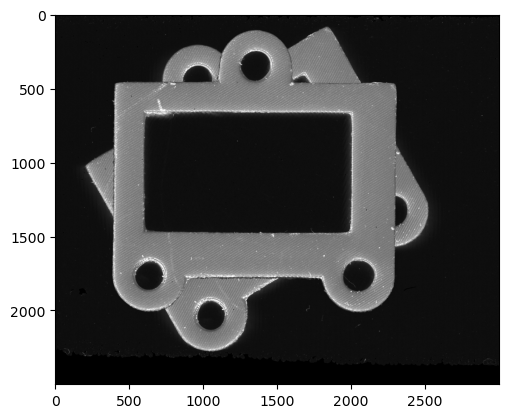

In [12]:
import cv2
import numpy as np

def isolate_object(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a binary threshold to get a binary mask
    _, binary = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assuming the largest contour is the object
    contour = max(contours, key=cv2.contourArea)
    
    # Create a mask for the object
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    
    # Extract the object
    object_image = cv2.bitwise_and(image, image, mask=mask)
    return object_image, mask, contour

def rotate_image(image, angle, center):
    (h, w) = image.shape[:2]
    
    # Get the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Perform the rotation on the image
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
    
    return rotated, M

def apply_rotation_to_mask(mask, M):
    (h, w) = mask.shape
    rotated_mask = cv2.warpAffine(mask, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return rotated_mask

def main():
    # Load the image
    image = cv2.imread(r"C:\Part_dimensions_project\cropped.jpg")
    
    # Isolate the object
    object_image, mask, contour = isolate_object(image)
    
    # Calculate the center of the object
    M = cv2.moments(contour)
    center_x = int(M["m10"] / M["m00"])
    center_y = int(M["m01"] / M["m00"])
    center = (center_x, center_y)
    
    # Rotate the object (e.g., by 45 degrees)
    angle = 330
    rotated_object, rotation_matrix = rotate_image(object_image, angle, center)
    rotated_mask = apply_rotation_to_mask(mask, rotation_matrix)
    
    # Combine the rotated object with the original background
    background = image.copy()
    background[rotated_mask > 0] = 0  # Clear the area where the object will be placed
    rotated_object_only = cv2.bitwise_and(rotated_object, rotated_object, mask=rotated_mask)
    combined_image = cv2.add(background, rotated_object_only)

    
    plt.imshow(combined_image)

if __name__ == "__main__":
    main()


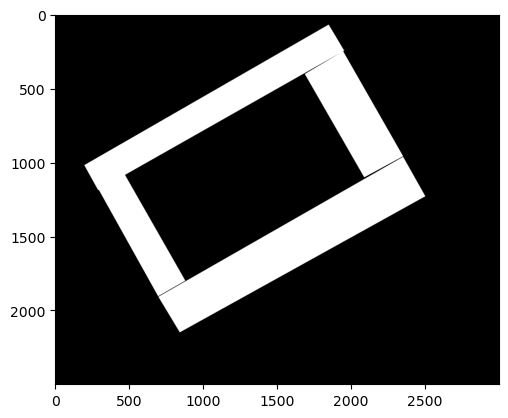

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread(r"C:\Part_dimensions_project\semantic_segmentation.png" , cv2.IMREAD_GRAYSCALE)



# print(image.shape)

image[image == 14] = 255

image[image == 38] = 255

image[image == 75] = 255

image[image == 113] = 255
# unique_colors = np.unique(image)
plt.imshow(image , cmap = 'gray')

# print(unique_colors)
# cv2.imwrite(r"C:\Part_dimensions_project\true_mask.jpg", image)

In [2]:
import cv2
import numpy as np

# Load the image
image = cv2.imread(r"C:\Part_dimensions_project\semantic_segmentation.png")

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding
_, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Loop through each contour
for i, contour in enumerate(contours):
    # Create a mask for the current contour
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [contour], -1, 255, -1)
    
    # Create a blank image for the background
    background = np.zeros_like(image)
    
    # Copy the contour region from the original image to the background
    background[mask == 255] = image[mask == 255]
    
    # Save the result
    cv2.imwrite(f'C:\Part_dimensions_project\segmented_region_{i+1}.png', background)
    
    # Optionally, display the result
    cv2.imshow(f'Segmented Region {i+1}', background)
    cv2.waitKey(0)

cv2.destroyAllWindows()


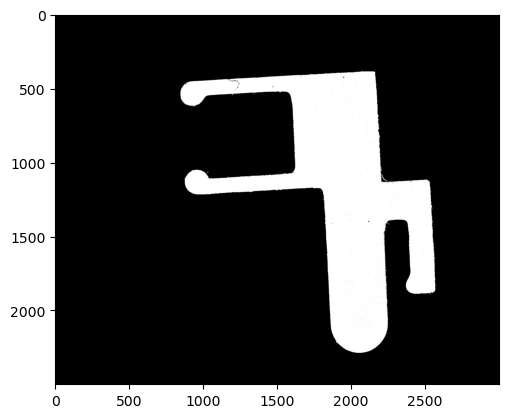

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def isolate_object(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a binary threshold to get a binary mask
    _, binary = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assuming the largest contour is the object
    contour = max(contours, key=cv2.contourArea)
    
    # Create a mask for the object
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    
    # Extract the object
    object_image = cv2.bitwise_and(image, image, mask=mask)
    return object_image, mask
    
def rotate_image(image, angle, mask=None):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    # Get the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Perform the rotation on the image
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
    
    # Rotate the mask if provided
    if mask is not None:
        rotated_mask = cv2.warpAffine(mask, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        return rotated, rotated_mask
    return rotated

def main():
    # Load the image
    image = cv2.imread(r"C:\Part_dimensions_project\parallel_cropped_binary.jpg")
    
    # Isolate the object
    object_image, mask = isolate_object(image)
    
    # Rotate the object (e.g., by 45 degrees)
    rotated_object, rotated_mask = rotate_image(object_image, 330, mask)
    
    # Combine the rotated object with a black background
    background = np.zeros_like(image)
    rotated_object_only = cv2.bitwise_and(rotated_object, rotated_object, mask=rotated_mask)
    combined_image = cv2.add(background, rotated_object_only)
    # Save or display the result
#     cv2.imwrite('rotated_object.png', combined_image)
    plt.imshow(combined_image)
    cv2.imwrite(r"C:\Part_dimensions_project\parallel_cropped_binary.jpg", combined_image)
if __name__ == "__main__":
    main()


In [13]:
import cv2
import os

# folder_path = r"C:\Part_dimensions_project\Seperated_folder"

counter = 0



for i in range (0 , 100):
    
#     files = os.listdir(folder_path)
#     for file in files:
#         image_path = os.path.join(folder_path, file)
#         image = cv2.imread(image_path)
#         # Isolate the object
#         object_image, mask = isolate_object(image)

#         # Rotate the object (e.g., by 45 degrees)
#         rotated_object, rotated_mask = rotate_image(object_image, 3.6, mask)

#         # Combine the rotated object with a black background
#         background = np.zeros_like(image)
#         rotated_object_only = cv2.bitwise_and(rotated_object, rotated_object, mask=rotated_mask)
#         combined_image = cv2.add(background, rotated_object_only)
        
#         cv2.imwrite(image_path , combined_image)
        
#     image_1 = cv2.imread(r"C:\Part_dimensions_project\Seperated_folder\segmented_region_1.png")
#     image_2 = cv2.imread(r"C:\Part_dimensions_project\Seperated_folder\segmented_region_2.png")
#     image_3 = cv2.imread(r"C:\Part_dimensions_project\Seperated_folder\segmented_region_3.png")
#     image_4 = cv2.imread(r"C:\Part_dimensions_project\Seperated_folder\segmented_region_4.png")
#     image_5 = cv2.imread(r"C:\Part_dimensions_project\Seperated_folder\segmented_region_5.png")
#     image_6 = cv2.imread(r"C:\Part_dimensions_project\Seperated_folder\segmented_region_6.png")
    
    
#     image_1_combined = cv2.add(image_1 , image_2)
#     image_2_combined = cv2.add(image_3 , image_4)
#     image_3_combined = cv2.add(image_5 , image_6)
#     mask_1 = cv2.add(image_1_combined , image_2_combined)
#     mask = cv2.add(mask_1 , image_3_combined)
    
#     cv2.imwrite(f"C:\Part_dimensions_project\masks_2\mask_{counter}.jpg" , mask)
    
    counter = counter + 1
    
    original_image = cv2.imread(r"C:\Part_dimensions_project\parallel_cropped_binary.jpg")
    # Isolate the object
    object_image, mask = isolate_object(original_image)
    
    # Rotate the object (e.g., by 45 degrees)
    rotated_object, rotated_mask = rotate_image(object_image, 3.6, mask)
    
    # Combine the rotated object with a black background
    background = np.zeros_like(image)
    rotated_object_only = cv2.bitwise_and(rotated_object, rotated_object, mask=rotated_mask)
    combined_image = cv2.add(background, rotated_object_only)
    
    cv2.imwrite(f"C:\Part_dimensions_project\ground_truth_2\part_image_{counter}.jpg" , combined_image)
    
    cv2.imwrite(r"C:\Part_dimensions_project\parallel_cropped_binary.jpg" , combined_image)
    
    

In [5]:
import os

import cv2


input_dir = r"C:\Part_dimensions_project\Masks"
output_dir = r"C:\Part_dimensions_project\Labels"

for j in os.listdir(input_dir):
    image_path = os.path.join(input_dir, j)
    # load the binary mask and get its contours
    mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

    H, W = mask.shape
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # convert the contours to polygons
    polygons = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 200:
            polygon = []
            for point in cnt:
                x, y = point[0]
                polygon.append(x / W)
                polygon.append(y / H)
            polygons.append(polygon)

    # print the polygons
    with open('{}.txt'.format(os.path.join(output_dir, j)[:-4]), 'w') as f:
        for polygon in polygons:
            for p_, p in enumerate(polygon):
                if p_ == len(polygon) - 1:
                    f.write('{}\n'.format(p))
                elif p_ == 0:
                    f.write('0 {} '.format(p))
                else:
                    f.write('{} '.format(p))

        f.close()

In [25]:
#run this cell for renaming

import os
import re

directory = r"C:\Part_dimensions_project\Semantic_Segmentation\Images\val\Images"

# Get a list of files in the directory
files = os.listdir(directory)

# Function to extract the integer value from the filename
def extract_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else -1

# Sort the files based on the extracted integer values
files.sort(key=extract_number)

# Loop through each file and rename it
for idx, file in enumerate(files):
    # Split the file name to get the extension
    file_name, file_extension = os.path.splitext(file)

    # Construct the new file name with the new index
    new_file_name = f'part_image_{191 + idx}{file_extension}'

    # Get the full path for the old and new file names
    old_file_path = os.path.join(directory, file)
    new_file_path = os.path.join(directory, new_file_name)

    # Rename the file
    os.rename(old_file_path, new_file_path)
    print(f'Renamed {old_file_path} to {new_file_path}')


Renamed C:\Part_dimensions_project\Semantic_Segmentation\Images\val\Images\shuffled_image_191.jpg to C:\Part_dimensions_project\Semantic_Segmentation\Images\val\Images\part_image_191.jpg
Renamed C:\Part_dimensions_project\Semantic_Segmentation\Images\val\Images\shuffled_image_192.jpg to C:\Part_dimensions_project\Semantic_Segmentation\Images\val\Images\part_image_192.jpg
Renamed C:\Part_dimensions_project\Semantic_Segmentation\Images\val\Images\shuffled_image_193.jpg to C:\Part_dimensions_project\Semantic_Segmentation\Images\val\Images\part_image_193.jpg
Renamed C:\Part_dimensions_project\Semantic_Segmentation\Images\val\Images\shuffled_image_194.jpg to C:\Part_dimensions_project\Semantic_Segmentation\Images\val\Images\part_image_194.jpg
Renamed C:\Part_dimensions_project\Semantic_Segmentation\Images\val\Images\shuffled_image_195.jpg to C:\Part_dimensions_project\Semantic_Segmentation\Images\val\Images\part_image_195.jpg
Renamed C:\Part_dimensions_project\Semantic_Segmentation\Images\v

In [5]:
import os
import random

def shuffle_files(directory1, directory2):
    # Get lists of files in both directories
    files1 = os.listdir(directory1)
    files2 = os.listdir(directory2)

    # Ensure both directories have the same number of files
    assert len(files1) == len(files2), "Directories must contain the same number of files."

    # Zip the lists together to maintain correspondence
    combined = list(zip(files1, files2))

    # Shuffle the combined list
    random.shuffle(combined)

    # Unzip the shuffled list
    shuffled_files1, shuffled_files2 = zip(*combined)

    # Rename files in directory1 (maintaining original names)
    for idx, (old_file1, new_file1) in enumerate(zip(files1, shuffled_files1)):
        old_path1 = os.path.join(directory1, old_file1)
        new_path1 = os.path.join(directory1, f"temp_{idx}{os.path.splitext(new_file1)[1]}")
        os.rename(old_path1, new_path1)

    # Rename files in directory2 (maintaining original names)
    for idx, (old_file2, new_file2) in enumerate(zip(files2, shuffled_files2)):
        old_path2 = os.path.join(directory2, old_file2)
        new_path2 = os.path.join(directory2, f"temp_{idx}{os.path.splitext(new_file2)[1]}")
        os.rename(old_path2, new_path2)

    # Now, rename temp files back to their original names
    for idx, new_file1 in enumerate(shuffled_files1):
        temp_path1 = os.path.join(directory1, f"temp_{idx}{os.path.splitext(new_file1)[1]}")
        final_path1 = os.path.join(directory1, new_file1)
        os.rename(temp_path1, final_path1)

    for idx, new_file2 in enumerate(shuffled_files2):
        temp_path2 = os.path.join(directory2, f"temp_{idx}{os.path.splitext(new_file2)[1]}")
        final_path2 = os.path.join(directory2, new_file2)
        os.rename(temp_path2, final_path2)

# Specify the directories
directory1 = r"C:\Part_dimensions_project\ground_truth_2"
directory2 = r"C:\Part_dimensions_project\labels_2"

# Call the function to shuffle files
shuffle_files(directory1, directory2)


In [21]:
#run this cell for shuffling

import os
import random
import shutil

def shuffle_and_rename(directory1, directory2):
    # Get lists of files in both directories
    files1 = os.listdir(directory1)
    files2 = os.listdir(directory2)

    # Ensure both directories have the same number of files
    assert len(files1) == len(files2), "Directories must contain the same number of files."
    
    
    def extract_number(filename):
        match = re.search(r'(\d+)', filename)
        return int(match.group(1)) if match else -1

    # Sort the files based on the extracted integer values
    files1.sort(key=extract_number)

    files2.sort(key=extract_number)
    
    
    # Zip the lists together to maintain correspondence
    combined = list(zip(files1, files2))

    # Shuffle the combined list
    random.shuffle(combined)

    # Unzip the shuffled list
    shuffled_files1, shuffled_files2 = zip(*combined)

    # Rename files in directory1
    for idx, file in enumerate(shuffled_files1):
        old_path = os.path.join(directory1, file)
        new_name = f"shuffled_image_{idx + 1}{os.path.splitext(file)[1]}"
        new_path = os.path.join(directory1, new_name)
        os.rename(old_path, new_path)

    # Rename files in directory2
    for idx, file in enumerate(shuffled_files2):
        old_path = os.path.join(directory2, file)
        new_name = f"shuffled_label_{idx + 1}{os.path.splitext(file)[1]}"
        new_path = os.path.join(directory2, new_name)
        os.rename(old_path, new_path)

# Specify the directories
directory1 = r"C:\Part_dimensions_project\ground_truth"
directory2 = r"C:\Part_dimensions_project\labels"

# Call the function to shuffle and rename files
shuffle_and_rename(directory1, directory2)


In [7]:
import yaml

data = {
    'path': 'C:\\Part_dimensions_project\\semantic_segmentation',  # dataset root dir
    'train': 'Images\\train',  # train images (relative to 'path') 4 images
    'val': 'images\\val',  # val images (relative to 'path') 4 images
    'test': '',  # test images (optional)
    'names': {
        0: 'parallel_thickness'
    }
}

# Convert the dictionary to a YAML file
yaml_path = r"C:\Part_dimensions_project\config.yaml"
with open(yaml_path, 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

print(f"YAML file created at: {yaml_path}")


YAML file created at: C:\Part_dimensions_project\config.yaml


In [16]:
import cv2
import numpy as np
import os

def resize_and_pad(image, target_size):
    original_h, original_w = image.shape[:2]
    target_h, target_w = target_size

    # Calculate the aspect ratio of the original image
    aspect_ratio = original_w / original_h

    # Determine the new size while maintaining aspect ratio
    if target_w / target_h > aspect_ratio:
        new_h = target_h
        new_w = int(aspect_ratio * target_h)
    else:
        new_w = target_w
        new_h = int(target_w / aspect_ratio)

    # Resize the image to the new size
    resized_image = cv2.resize(image, (new_w, new_h))

    # Create a new image with the target size and a black background
    padded_image = np.zeros((target_h, target_w, 3), dtype=np.uint8)

    # Calculate padding to center the resized image
    pad_top = (target_h - new_h) // 2
    pad_bottom = target_h - new_h - pad_top
    pad_left = (target_w - new_w) // 2
    pad_right = target_w - new_w - pad_left

    # Place the resized image on the padded background
    padded_image[pad_top:pad_top+new_h, pad_left:pad_left+new_w] = resized_image

    return padded_image

def resize_images_in_folder(input_folder, target_size):
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.jpg') or file_name.endswith('.jpeg') or file_name.endswith('.png'):
            file_path = os.path.join(input_folder, file_name)
            image = cv2.imread(file_path)
            if image is not None:
                resized_padded_image = resize_and_pad(image, target_size)
                cv2.imwrite(file_path, resized_padded_image)
                #print(f"Resized and saved {file_path}")
            else:
                print(f"Failed to read {file_path}")

# Folder containing images to resize
input_folder = r"C:\Part_dimensions_project\ground_truth"
target_size = (500, 500)  # Target size

resize_images_in_folder(input_folder, target_size)

print("All images resized and saved.")


All images resized and saved.


In [4]:
import cv2
import numpy as np

def resize_and_pad(image, target_size):
    original_h, original_w = image.shape[:2]
    target_h, target_w = target_size

    # Calculate the aspect ratio of the original image
    aspect_ratio = original_w / original_h

    # Determine the new size while maintaining aspect ratio
    if target_w / target_h > aspect_ratio:
        new_h = target_h
        new_w = int(aspect_ratio * target_h)
    else:
        new_w = target_w
        new_h = int(target_w / aspect_ratio)

    # Resize the image to the new size
    resized_image = cv2.resize(image, (new_w, new_h))

    # Create a new image with the target size and a black background
    padded_image = np.zeros((target_h, target_w, 3), dtype=np.uint8)

    # Calculate padding to center the resized image
    pad_top = (target_h - new_h) // 2
    pad_bottom = target_h - new_h - pad_top
    pad_left = (target_w - new_w) // 2
    pad_right = target_w - new_w - pad_left

    # Place the resized image on the padded background
    padded_image[pad_top:pad_top+new_h, pad_left:pad_left+new_w] = resized_image

    return padded_image

# Example usage
input_image_path = r"C:\Users\Navdeep\Downloads\Big_circle.tif"
output_image_path = r"C:\Users\Navdeep\Downloads\Big_circle.tif"
target_size = (500, 500)  # Change to (614, 614) if needed

image = cv2.imread(input_image_path)
resized_padded_image = resize_and_pad(image, target_size)
cv2.imwrite(output_image_path, resized_padded_image)

print(f"Image resized and saved to {output_image_path}")


Image resized and saved to C:\Users\Navdeep\Downloads\Big_circle.tif


In [2]:
from ultralytics import YOLO

model = YOLO(r"C:\Users\Navdeep\runs\segment\train3\weights\last.pt")

results = model.train(data=r"C:\Part_dimensions_project\config.yaml", epochs=50, imgsz=500)

New https://pypi.org/project/ultralytics/8.2.58 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.0 🚀 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=segment, mode=train, model=C:\Users\Navdeep\runs\segment\train3\weights\last.pt, data=C:\Part_dimensions_project\config.yaml, epochs=50, time=None, patience=50, batch=16, imgsz=500, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train13, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnost

train: Scanning C:\Part_dimensions_project\Semantic_Segmentation\labels\train.cache... 190 images, 0 backgrounds, 0 cor
val: Scanning C:\Part_dimensions_project\Semantic_Segmentation\labels\val.cache... 10 images, 0 backgrounds, 0 corrupt:


Plotting labels to runs\segment\train13\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.0005), 116 bias(decay=0.0)
50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.81G     0.7836      1.026     0.7407      1.163        102        512: 100%|██████████| 12/12 [02:00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10         38      0.902       0.73      0.869      0.635       0.88      0.842       0.92      0.687



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      10.2G     0.8309      1.069     0.7792      1.183        142        512: 100%|██████████| 12/12 [02:16
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all         10         38      0.702      0.867      0.838        0.6      0.813      0.921      0.884      0.665



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      10.3G     0.8166      1.043     0.7795      1.169        128        512:  67%|██████▋   | 8/12 [01:21<


KeyboardInterrupt: 

In [3]:
from IPython.display import display
from ultralytics import YOLO

# Load a custom model
model = YOLO(r"C:\Users\Navdeep\runs\segment\train3\weights\best.pt")

# Predict with the model using a local image path
results = model(r"C:\Part_dimensions_project\Semantic_Segmentation\images\val\part_image_194.jpg")  # Replace with the actual path to your image

# Display the image with predictions inline in a Jupyter notebook
results.show(display=True)



image 1/1 C:\Part_dimensions_project\Semantic_Segmentation\images\val\part_image_194.jpg: 512x512 6 parallel_thicknesss, 94.9ms
Speed: 6.1ms preprocess, 94.9ms inference, 6.0ms postprocess per image at shape (1, 3, 512, 512)


AttributeError: 'list' object has no attribute 'show'

In [2]:
from ultralytics import YOLO

# Load a model

model = YOLO(r"C:\Users\Navdeep\runs\segment\train3\weights\best.pt")  # load a custom model

# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map  # map50-95(B)
metrics.box.map50  # map50(B)
metrics.box.map75  # map75(B)
metrics.box.maps  # a list contains map50-95(B) of each category
metrics.seg.map  # map50-95(M)
metrics.seg.map50  # map50(M)
metrics.seg.map75  # map75(M)
metrics.seg.maps  # a list contains map50-95(M) of each category

Ultralytics YOLOv8.1.0 🚀 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8x-seg summary (fused): 295 layers, 71721619 parameters, 0 gradients, 343.7 GFLOPs


val: Scanning C:\Part_dimensions_project\Semantic_Segmentation\labels\val.cache... 10 images, 0 backgrounds, 0 corrupt:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all         10         38      0.634      0.868      0.831      0.639      0.737      0.959      0.897      0.669
Speed: 2.2ms preprocess, 57.8ms inference, 0.0ms loss, 6.3ms postprocess per image
Results saved to runs\segment\val


array([    0.66947])

In [6]:
from ultralytics import YOLO

# Load a pretrained YOLOv8n model
model = YOLO(r"C:\Users\Navdeep\runs\segment\train3\weights\best.pt")

# Run inference on 'bus.jpg' with arguments
result = model.predict(r"C:\Part_dimensions_project\Semantic_Segmentation\images\val\part_image_191.jpg", save=False, imgsz=500)


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
image 1/1 C:\Part_dimensions_project\Semantic_Segmentation\images\val\part_image_191.jpg: 512x512 4 parallel_thicknesss, 118.0ms
Speed: 0.0ms preprocess, 118.0ms inference, 11.0ms postprocess per image at shape (1, 3, 512, 512)


True

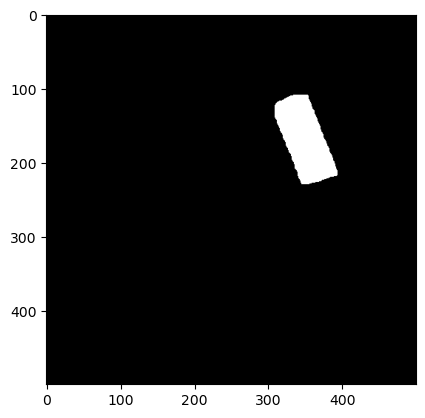

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
masks = result[0]


pixel_coords = masks.masks.xy

coords = pixel_coords[0]
# points = np.array(coords)
# for coords in pixel_coords:
#     x_coords, y_coords = zip(*coords)  # Unzip coordinates
#     ax.scatter(x_coords, y_coords, color='red', s=1)  # Plot each point as a white pixel
x_coords, y_coords = zip(*coords)

# rect = cv2.minAreaRect(points)
# box = cv2.boxPoints(rect)
# box = np.intp(box)
x_coords = list(x_coords)
y_coords = list(y_coords)
x_coords.append(x_coords[-1])
x_coords.append(x_coords[0])
y_coords.append(y_coords[-1])
y_coords.append(y_coords[0])
x_coords = tuple(x_coords)
y_coords = tuple(y_coords)

coords = []
for i in range(len(x_coords)):
    coords.append([round(x_coords[i]), round(y_coords[i])])
    
coords_np = np.array(coords)

# rect = cv2.minAreaRect(np.array(coords))
height, width = 500, 500

black_background = np.zeros((height, width, 1), dtype=np.uint8)

# center, size, angle = rect

# Calculate the rotation matrix to align the rectangle
# Adjust angle if necessary (e.g., for 90-degree rotations)
# rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

# Perform the affine transformation (rotation)
# rotated = cv2.warpAffine(, rotation_matrix, (image.shape[1], image.shape[0]))

color = ( 255)  # BGR format: red color
cv2.fillPoly(black_background, [coords_np], color)
# for i in range(len(pixel_coords)):
#     coords = pixel_coords[i]
# for coord in coords:
#     x, y = coord
#     if 0 <= x < width and 0 <= y < height:
#         black_background[round(y), round(x)] = [255] 
            
plt.imshow(black_background , cmap = 'gray')  

cv2.imwrite(r"C:\Part_dimensions_project\experimental_image_3.jpg" , black_background)

In [ ]:
import cv2
import numpy as np

# Load the image
image = cv2.imread('path_to_image')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assume the largest contour is the rectangle
contour = max(contours, key=cv2.contourArea)

# Get the minimum area bounding box
rect = cv2.minAreaRect(contour)
box = cv2.boxPoints(rect)
box = np.int0(box)

# Draw the contour and the bounding box (optional, for visualization)
cv2.drawContours(image, [box], 0, (0, 255, 0), 2)

# Get the center, size, and angle of the bounding box
center, size, angle = rect

# Calculate the rotation matrix to align the rectangle
# Adjust angle if necessary (e.g., for 90-degree rotations)
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

# Perform the affine transformation (rotation)
rotated = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

# (Optional) Crop the rotated image to the bounding box
width, height = int(size[0]), int(size[1])
cropped = cv2.getRectSubPix(rotated, (width, height), center)

# Display the result
cv2.imshow('Original Image', image)
cv2.imshow('Rotated Image', rotated)
cv2.imshow('Cropped Rectangle', cropped)
cv2.waitKey(0)
cv2.destroyAllWindows()


68.14970397949219


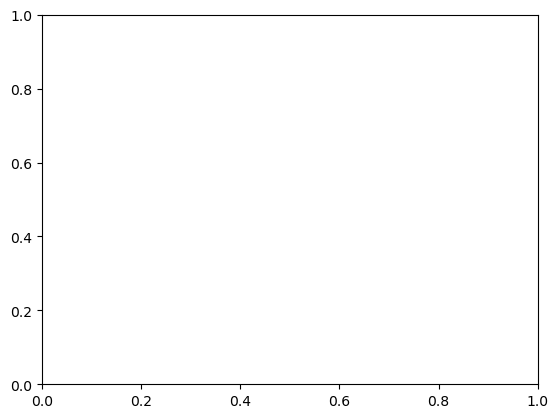

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have 'result' containing masks and pixel coordinates
masks = result[0]
pixel_coords = masks.masks.xy

height, width = 500, 500

# Create a figure and axis for plotting
fig, ax = plt.subplots()

# Plot each pixel coordinate as a white point
coords = pixel_coords[3]
# points = np.array(coords)
# for coords in pixel_coords:
#     x_coords, y_coords = zip(*coords)  # Unzip coordinates
#     ax.scatter(x_coords, y_coords, color='red', s=1)  # Plot each point as a white pixel
x_coords, y_coords = zip(*coords)

# rect = cv2.minAreaRect(points)
# box = cv2.boxPoints(rect)
# box = np.intp(box)
x_coords = list(x_coords)
y_coords = list(y_coords)
x_coords.append(x_coords[-1])
x_coords.append(x_coords[0])
y_coords.append(y_coords[-1])
y_coords.append(y_coords[0])
x_coords = tuple(x_coords)
y_coords = tuple(y_coords)

coords = []
for i in range(len(x_coords)):
    coords.append([x_coords[i], y_coords[i]])
    
points = np.array(coords)

_ , _ , angle = cv2.minAreaRect(points)
# box = cv2.boxPoints(rect)
# box = np.intp(box)
# ax.plot(x_coords, y_coords, color='red')
# ax.fill(x_coords, y_coords, color='red', alpha=0.3) 
# # ax.plot([x_coords[-1] , x_coords[0]] , [y_coords[-1] , y_coords[0]] , color = 'red')
# # Set plot limits and aspect ratio
# ax.set_xlim(0, width)
# ax.set_ylim(0, height)
# ax.set_aspect('equal')  # Ensure aspect ratio is equal

# Hide axes if not needed
# ax.axis('off')
# ax.plot(box[:, 0], box[:, 1], color='blue', linestyle='--')
# ax.invert_yaxis()
# # Display the plot
# plt.show()

print(angle)

In [21]:
contour_coords = np.array([[50, 50], [100, 50], [100, 100], [50, 100]])
print(contour_coords)

[[ 50  50]
 [100  50]
 [100 100]
 [ 50 100]]


In [29]:
from ultralytics import YOLO

model = YOLO(r"C:\Users\Navdeep\Downloads\yolov8x-seg.pt")

results = model.train(data=r"C:\Part_dimensions_project\config_2.yaml", epochs=100, imgsz=500)

New https://pypi.org/project/ultralytics/8.2.58 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.0 🚀 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=segment, mode=train, model=C:\Users\Navdeep\Downloads\yolov8x-seg.pt, data=C:\Part_dimensions_project\config_2.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=500, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=F

train: Scanning C:\Part_dimensions_project\Semantic_segmentation_2\labels\train... 300 images, 0 backgrounds, 0 corrupt

train: New cache created: C:\Part_dimensions_project\Semantic_segmentation_2\labels\train.cache



val: Scanning C:\Part_dimensions_project\Semantic_segmentation_2\labels\val... 3 images, 0 backgrounds, 0 corrupt: 100%

val: New cache created: C:\Part_dimensions_project\Semantic_segmentation_2\labels\val.cache


Plotting labels to runs\segment\train11\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.0005), 116 bias(decay=0.0)
100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      10.7G      2.235      3.678      3.867      2.237         70        512: 100%|██████████| 19/19 [04:07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all          3         11    0.00812      0.636    0.00798    0.00272    0.00464      0.364    0.00357    0.00167



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100        11G      1.359       1.89      1.783      1.352         64        512: 100%|██████████| 19/19 [04:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all          3         11    0.00812      0.636    0.00798    0.00272    0.00464      0.364    0.00357    0.00167



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      11.2G      1.056       1.37      1.284      1.202         77        512: 100%|██████████| 19/19 [03:25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all          3         11    0.00812      0.636    0.00798    0.00272    0.00464      0.364    0.00357    0.00167



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      11.2G      1.004      1.228      1.008      1.175         78        512: 100%|██████████| 19/19 [03:33
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all          3         11     0.0014     0.0909   0.000652    0.00039          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      11.2G     0.9036      1.038     0.9515      1.108         62        512: 100%|██████████| 19/19 [02:55
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all          3         11     0.0161     0.0909    0.00233    0.00112          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      11.2G     0.9231     0.9426     0.9121      1.086         87        512: 100%|██████████| 19/19 [03:56
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all          3         11     0.0044      0.273    0.00294    0.00123          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      11.2G     0.8375     0.9822      0.806      1.083         45        512: 100%|██████████| 19/19 [04:06
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all          3         11     0.0044      0.273    0.00294    0.00123          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      11.2G     0.7391     0.8187      0.693     0.9994        109        512:  89%|████████▉ | 17/19 [03:17


KeyboardInterrupt: 

In [2]:
from ultralytics import YOLO

# Load a pretrained YOLOv8n model
model = YOLO(r"C:\Users\Navdeep\runs\segment\train11\weights\best.pt")

# Run inference on 'bus.jpg' with arguments
model.predict(r"C:\Part_dimensions_project\Semantic_segmentation_2\images\val\cropped.jpg", save=True, imgsz=500)


WARNING ⚠️ imgsz=[500] must be multiple of max stride 32, updating to [512]
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 C:\Part_dimensions_project\Semantic_segmentation_2\images\val\cropped.jpg: 512x512 300 parallel_thicknesss, 231.2ms
Speed: 20.5ms preprocess, 231.2ms inference, 1403.6ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs\segment\predict6


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: 'parallel_thickness'}
 obb: None
 orig_img: array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         .

In [28]:
import os
import shutil

# Define the original file path
original_file_path = r"C:\Part_dimensions_project\Semantic_segmentation_2\labels\train\parallel_cropped.txt"

# Define the directory containing the file
directory = os.path.dirname(original_file_path)

# Define the base name and extension
base_name = os.path.basename(original_file_path)
name, extension = os.path.splitext(base_name)

# Define the number of copies you want to make
num_copies = 100  # Adjust this number as needed

# Loop to create and rename copies
for i in range(1, num_copies + 1):
    new_file_name = f"{name}_{i}{extension}"
    new_file_path = os.path.join(directory, new_file_name)
    
    # Copy the original file to the new path
    shutil.copy(original_file_path, new_file_path)

print(f"Created {num_copies} copies of {original_file_path} in {directory}")


Created 100 copies of C:\Part_dimensions_project\Semantic_segmentation_2\labels\train\parallel_cropped.txt in C:\Part_dimensions_project\Semantic_segmentation_2\labels\train
